<a href="https://colab.research.google.com/github/vivekbiragoni/social_computing/blob/main/Social_computing_gnn_clsf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import networkx as nx

In [2]:
my_nodes = list(range(5))
H = nx.DiGraph()


In [4]:
H.add_nodes_from(my_nodes)

# add edges
H.add_edges_from([
    (1,0),
    (1,2),
    (1,3),
    (3,2),
    (3,4),
    (4,0)
])

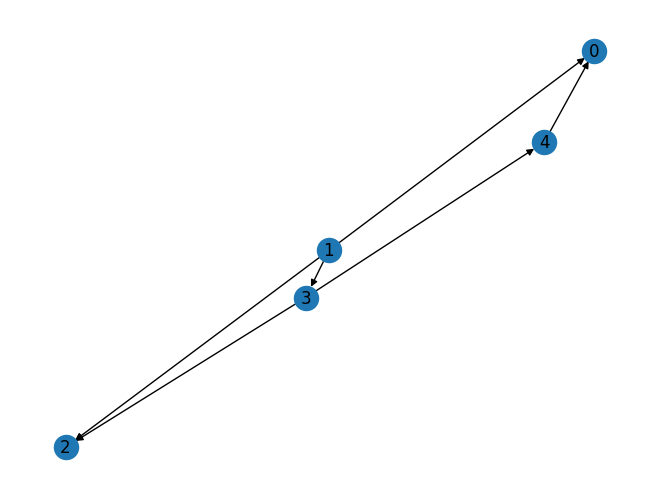

In [5]:

nx.draw(H, with_labels=True)

In [6]:



# get dense adjacency matrix
nx.adjacency_matrix(H).todense()

array([[0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0]])

In [7]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GATConv
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
import seaborn as snn

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 88.0 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 41.0 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.9 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.8 MB/s eta 0:00:00


In [8]:

dataset = Planetoid(root='/content/sample_data/data', name='PubMed', transform=NormalizeFeatures())
print(f"Datset: { dataset}")
print(f"# graph: {len(dataset)}")
print(f"# features: {dataset.num_features }")
print(f"# classes: {dataset.num_classes}")

data = dataset[0]
print(data)

Processing...


Datset: PubMed()
# graph: 1
# features: 500
# classes: 3
Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


Done!


In [9]:

data.edge_index

tensor([[    0,     0,     0,  ..., 19714, 19715, 19716],
        [ 1378,  1544,  6092,  ..., 12278,  4284, 16030]])

In [10]:

data.edge_index.shape

torch.Size([2, 88648])

In [11]:

from collections import Counter
Counter(data.y.cpu().numpy())

Counter({1: 7739, 0: 4103, 2: 7875})

In [12]:
class GCN(torch.nn.Module):
    def __init__(self, num_hidden, num_features, num_classes) -> None:
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, num_hidden)
        self.conv2 = GCNConv(num_hidden, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [13]:

model = GCN(num_hidden=16, num_features=dataset.num_features, num_classes= dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [14]:

# MOdle trainign
loss_lst = []
model.train()
for epoch in range(1000):
  optimizer.zero_grad()
  y_pred = model(data.x, data.edge_index)
  y_true = data.y
  loss = criterion(y_pred[data.train_mask],y_true[data.train_mask])
  loss_lst.append(loss.item())
  loss.backward()
  optimizer.step()
  print(f"Epoch:  {epoch}, Loss: {loss}")

Epoch:  0, Loss: 1.0989083051681519
Epoch:  1, Loss: 1.097924828529358
Epoch:  2, Loss: 1.0972579717636108
Epoch:  3, Loss: 1.096683382987976
Epoch:  4, Loss: 1.0959758758544922
Epoch:  5, Loss: 1.0947072505950928
Epoch:  6, Loss: 1.0945191383361816
Epoch:  7, Loss: 1.093458652496338
Epoch:  8, Loss: 1.0926719903945923
Epoch:  9, Loss: 1.0918561220169067
Epoch:  10, Loss: 1.0907553434371948
Epoch:  11, Loss: 1.0900200605392456
Epoch:  12, Loss: 1.089233160018921
Epoch:  13, Loss: 1.0886629819869995
Epoch:  14, Loss: 1.0865055322647095
Epoch:  15, Loss: 1.0855128765106201
Epoch:  16, Loss: 1.086074948310852
Epoch:  17, Loss: 1.0835598707199097
Epoch:  18, Loss: 1.0825843811035156
Epoch:  19, Loss: 1.08046555519104
Epoch:  20, Loss: 1.0803180932998657
Epoch:  21, Loss: 1.079797387123108
Epoch:  22, Loss: 1.0788546800613403
Epoch:  23, Loss: 1.0770514011383057
Epoch:  24, Loss: 1.0783566236495972
Epoch:  25, Loss: 1.076046109199524
Epoch:  26, Loss: 1.0743085145950317
Epoch:  27, Loss: 1.

<Axes: >

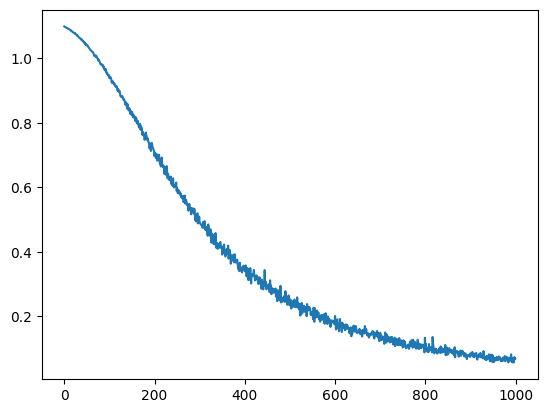

In [15]:

# train loss
snn.lineplot(x=list(range(len(loss_lst))),y = loss_lst)

In [16]:

# model evaluation
model.eval()
with torch.no_grad():
  y_pred = model(data.x, data.edge_index)
  y_pred_cls = y_pred.argmax(dim=1)
  correct_pred = y_pred_cls[data.test_mask] == data.y[data.test_mask]
  data.y[data.test_mask]
  test_acc = int(correct_pred.sum())/int(data.test_mask.sum())
print(f"Test accuracy: {test_acc}")

Test accuracy: 0.771


<Axes: >

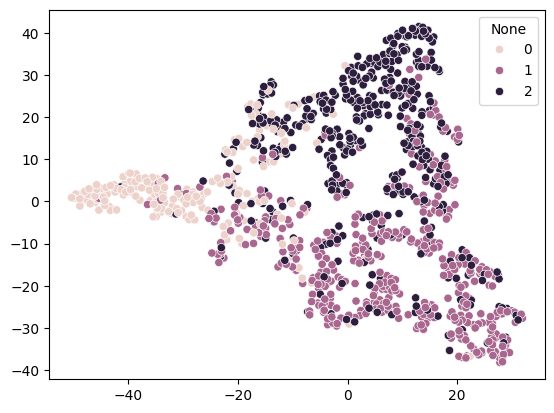

In [17]:

# visualizations

z = TSNE(n_components=2).fit_transform(y_pred[data.test_mask].detach().cpu().numpy())
snn.scatterplot(x=z[:,0],y=z[:,1],hue=data.y[data.test_mask])